In [7]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import joblib 

In [8]:
tickers = ["XOM", "CVX", "COP", "NEE", "ENB", "SLB", "KMI", "EOG","SHEL", "TTE"]

end = datetime.now()
start = "2015-01-01"


In [9]:
def plot_graph(figsize, values, column_name, stock):
    plt.figure()
    values.plot(figsize = figsize)
    plt.xlabel("Years")
    plt.ylabel(column_name)
    plt.title(f"{column_name} of {stock} data")
    plt.show()

In [10]:
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=50, activation='tanh', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=50, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=50, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=50))
    model.add(Dropout(0.2))
    # Output layer
    model.add(Dense(units=1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

In [11]:
# Thư mục lưu mô hình và scaler
MODEL_DIR = "../models"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

Đang xử lý mã cổ phiếu: XOM


[*********************100%***********************]  1 of 1 completed


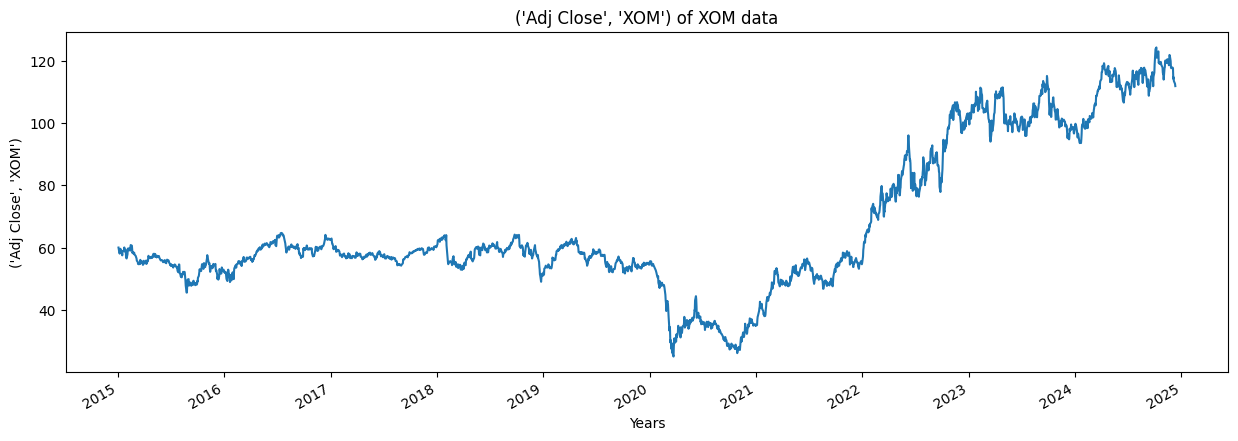

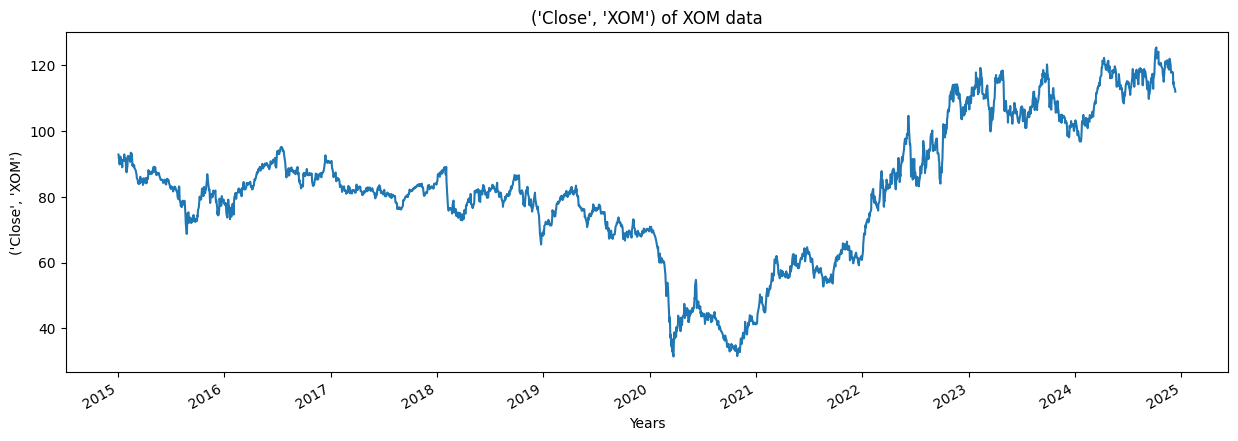

In [ ]:
for stock in tickers:
    print(f"Đang xử lý mã cổ phiếu: {stock}")
    data = yf.download(stock, start=start, end=end)
    if data.empty:
        print(f"Không có dữ liệu cho {stock}, bỏ qua.")
        continue
    
    
    for column in data.columns:
        plot_graph((15,5), data[column], column, stock)
    
    # Prepare data
    if 'Close' not in data.columns:
        print(f"Dữ liệu {stock} không có cột 'Close', bỏ qua.")
        continue

    dataset = data['Close'].values.reshape(-1, 1)
    if len(dataset) < 200:
        print(f"Dữ liệu cho {stock} quá ít ({len(dataset)} điểm), bỏ qua.")
        continue

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset_scaled = scaler.fit_transform(dataset)
    
    # Prepare the data with time steps (10 previous days)
    n_steps_rnn = 10
    X = []
    y = []
    for i in range(n_steps_rnn, len(dataset_scaled)):
        X.append(dataset_scaled[i - n_steps_rnn:i, 0])
        y.append(dataset_scaled[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], n_steps_rnn, 1))
    y = np.reshape(y, (y.shape[0], 1))

    # K-Fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_mse = []
    train_rmse = []
    train_mae = []
    test_mse = []
    test_rmse = []
    test_mae = []
    r2_train = []
    r2_test = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model = build_rnn_model((X.shape[1], 1))
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

        # Predict on training data
        y_train_pred = model.predict(X_train)
        y_train_pred = scaler.inverse_transform(y_train_pred)
        y_train_actual = scaler.inverse_transform(y_train)

        # Predict on validation data (test data for this fold)
        y_val_pred = model.predict(X_val)
        y_val_pred = scaler.inverse_transform(y_val_pred)
        y_val_actual = scaler.inverse_transform(y_val)

        # Calculate metrics for training data
        train_mse.append(mean_squared_error(y_train_actual, y_train_pred))
        train_rmse.append(np.sqrt(mean_squared_error(y_train_actual, y_train_pred)))
        train_mae.append(mean_absolute_error(y_train_actual, y_train_pred))
        r2_train.append(r2_score(y_train_actual, y_train_pred))

        # Calculate metrics for validation data (test data for this fold)
        test_mse.append(mean_squared_error(y_val_actual, y_val_pred))
        test_rmse.append(np.sqrt(mean_squared_error(y_val_actual, y_val_pred)))
        test_mae.append(mean_absolute_error(y_val_actual, y_val_pred))
        r2_test.append(r2_score(y_val_actual, y_val_pred))

   
    print(f"{stock} - Train MSE: {np.mean(train_mse)}")
    print(f"{stock} - Train RMSE: {np.mean(train_rmse)}")
    print(f"{stock} - Train MAE: {np.mean(train_mae)}")
    print(f"{stock} - Train R-squared: {np.mean(r2_train)}")
    print(f"{stock} - Test MSE: {np.mean(test_mse)}")
    print(f"{stock} - Test RMSE: {np.mean(test_rmse)}")
    print(f"{stock} - Test MAE: {np.mean(test_mae)}")
    print(f"{stock} - Test R-squared: {np.mean(r2_test)}")

    # Visualizing predicted vs actual prices 

    plt.figure(figsize=(15, 6))
    plt.plot(y_val_actual, color='g', label='Actual')
    plt.plot(y_val_pred, color='b', label='Predicted')
    plt.xlabel('Days')
    plt.ylabel('Close Price')
    plt.title(f'RNN Model - Predicted vs Actual Prices (Validation Set) for {stock}')
    plt.legend()
    plt.show()

   
    last_10_days = dataset_scaled[-n_steps_rnn:] 
    last_10_days = np.reshape(last_10_days, (1, n_steps_rnn, 1))  
    predicted_price = model.predict(last_10_days)
    predicted_price = scaler.inverse_transform(predicted_price)

    print(f"{stock} Predicted price for the next day: ${predicted_price[0][0]:.2f}\n")

    # Save model
    model_path = os.path.join(MODEL_DIR, f"RNN_model_{stock}.keras")
    model.save(model_path)